# Aperture photometry

This notebook was generated at 2024-09-25 20:50:10 (KST = GMT+0900) 
0 Python     3.12.3 64bit [GCC 11.2.0]
1 IPython    8.25.0
2 OS         Linux 5.15.0 122 generic x86_64 with glibc2.31
3 numpy      1.26.4
4 pandas     2.2.2
5 matplotlib 3.8.4
6 scipy      1.13.1
7 astropy    6.1.0
8 astroquery 0.4.7
9 photutils  1.12.0
10 ysfitsutilpy 0.2
11 ysphotutilpy 0.1.1
12 ccdproc    2.4.2
13 aplpy      2.1.0
14 version_information 1.0.4

0 Python     3.12.3 64bit [GCC 11.2.0]
1 IPython    8.25.0
2 OS         Linux 5.15.0 119 generic x86_64 with glibc2.31
3 numpy      1.26.4
4 pandas     2.2.2
5 matplotlib 3.8.4
6 scipy      1.13.1
7 astropy    6.1.0
8 astroquery 0.4.7
9 photutils  1.12.0
10 ysfitsutilpy 0.2
11 ysphotutilpy 0.1.1
12 ccdproc    2.4.2
13 aplpy      2.1.0
14 version_information 1.0.4

### import modules

In [ ]:
#%%
from glob import glob
from pathlib import Path
import os
import platform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from astropy.io import fits
from astropy.wcs import WCS
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz

import astropy.units as u

import ysfitsutilpy as yfu
import ysphotutilpy as ypu

import _astro_utilities
import _Python_utilities

from photutils.detection import DAOStarFinder
from astropy.stats import sigma_clipped_stats

from photutils.aperture import CircularAperture as CAp
from photutils.aperture import CircularAnnulus as CAn
from photutils.aperture import aperture_photometry as apphot

from scipy.optimize import curve_fit

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#%%
verbose = True # False
tryagain = False
file_age = 365
trynightsky = True
#######################################################
BASEDIR = Path("/mnt/Rdata/ASTRO_data") 
if platform.system() == "Windows":
    BASEDIR = Path("R:\\ASTRO_data") 

PROJECDIR = BASEDIR / "C1-Variable"
TODODIR = PROJECDIR / "-_-_-_2016-_-_RiLA600_STX-16803_-_2bin"
TODODIR = PROJECDIR / "-_-_-_2017-01_-_RiLA600_STX-16803_-_2bin"
TODODIR = PROJECDIR / "-_-_-_2017-03_-_RiLA600_STX-16803_-_2bin"
TODODIR = PROJECDIR / "-_-_-_2017-05_-_RiLA600_STX-16803_-_2bin"
# TODODIR = PROJECDIR / "-_-_-_2017-06_-_RiLA600_STX-16803_-_2bin"
# TODODIR = PROJECDIR / "-_-_-_2021-10_-_RiLA600_STX-16803_-_2bin"
# TODODIR = PROJECDIR / "-_-_-_2022-01_-_RiLA600_STX-16803_-_2bin"

# PROJECDIR = BASEDIR / "C2-Asteroid"
# TODODIR = PROJECDIR / "-_-_-_2022-_-_GSON300_STF-8300M_-_1bin"
# TODODIR = PROJECDIR / "-_-_-_2022-_-_RiLA600_STX-16803_-_1bin"
# TODODIR = PROJECDIR / "-_-_-_2022-_-_RiLA600_STX-16803_-_2bin"
# TODODIR = PROJECDIR / "-_-_-_2023-_-_GSON300_STF-8300M_-_1bin"
# TODODIR = PROJECDIR / "-_-_-_2023-_-_RiLA600_STX-16803_-_1bin"
# TODODIR = PROJECDIR / "-_-_-_2023-_-_RiLA600_STX-16803_-_2bin"

PROJECDIR = BASEDIR / "C3-EXO"
# TODODIR = PROJECDIR / "-_-_-_2024-05_-_GSON300_STF-8300M_-_1bin"
# TODODIR = PROJECDIR / "-_-_-_2024-05_-_RiLA600_STX-16803_-_1bin"
# TODODIR = PROJECDIR / "-_-_-_2024-06_-_GSON300_STF-8300M_-_1bin"
# TODODIR = PROJECDIR / "-_-_-_2024-06_-_RiLA600_STX-16803_-_2bin"
# TODODIR = PROJECDIR / "-_-_-_2024-09_-_GSON300_STF-8300M_-_1bin"
# TODODIR = PROJECDIR / "-_-_-_2024-09_-_RiLA600_ASI6200MMPro_-_2bin"
TODODIR = PROJECDIR / "-_-_-_2024-11_-_GSON300_STF-8300M_-_1bin"
TODODIR = PROJECDIR / "-_-_-_2024-11_-_RiLA600_ASI6200MMPro_-_3bin"

# PROJECDIR = BASEDIR / "C4-Spectra"
# TODODIR = PROJECDIR / "-_-_-_2024-05_TEC140_ASI183MMPro_-_1bin"

DOINGDIRs = sorted(_Python_utilities.getFullnameListOfsubDirs(TODODIR))
if verbose == True :
    print ("DOINGDIRs: ", format(DOINGDIRs))
    print ("len(DOINGDIRs): ", format(len(DOINGDIRs)))

try : 
    BDFDIR = [x for x in DOINGDIRs if "CAL-BDF" in str(x)]
    if verbose == True :
        print ("BDFDIR: ", format(BDFDIR))
    MASTERDIR = Path(BDFDIR[0]) / _astro_utilities.master_dir
    if not MASTERDIR.exists():
        os.makedirs("{}".format(str(MASTERDIR)))
        if verbose == True :
            print("{} is created...".format(str(MASTERDIR)))
            print ("MASTERDIR: ", format(MASTERDIR))
except Exception as err :
    if verbose == True : 
        print("X"*60)
    _Python_utilities.write_log(err_log_file, f'''{fpath}, {str(err)}''', verbose=verbose)
    pass

DOINGDIRs = sorted([x for x in DOINGDIRs if "_LIGHT_" in str(x)])
# print ("DOINGDIRs: ", format(DOINGDIRs))
# print ("len(DOINGDIRs): ", format(len(DOINGDIRs)))

# filter_str = '2017-01-13'
# DOINGDIRs = [x for x in DOINGDIRs if filter_str in str(x)]
# remove = 'BIAS'
# DOINGDIRs = [x for x in DOINGDIRs if remove not in x]
# remove = 'DARK'
# DOINGDIRs = [x for x in DOINGDIRs if remove not in x]
# remove = 'FLAT'
# DOINGDIRs = [x for x in DOINGDIRs if remove not in x]
if verbose == True :
    print ("DOINGDIRs: ", DOINGDIRs)
    print ("len(DOINGDIRs): ", len(DOINGDIRs))
#######################################################

DOINGDIRs:  ['/mnt/Rdata/ASTRO_data/C3-EXO/-_-_-_2024-11_-_RiLA600_ASI6200MMPro_-_3bin/-_CAL-BDF_-_2024-11_-_GSON300_STF-8300M_-_3bin/', '/mnt/Rdata/ASTRO_data/C3-EXO/-_-_-_2024-11_-_RiLA600_ASI6200MMPro_-_3bin/HAT-P-25b_LIGHT_-_2024-12-22_-_RiLA600_ASI6200MMPro_-_3bin/', '/mnt/Rdata/ASTRO_data/C3-EXO/-_-_-_2024-11_-_RiLA600_ASI6200MMPro_-_3bin/HAT-P-62b_LIGHT_-_2024-12-18_-_RiLA600_ASI6200MMPro_-_3bin/', '/mnt/Rdata/ASTRO_data/C3-EXO/-_-_-_2024-11_-_RiLA600_ASI6200MMPro_-_3bin/HAT-P-62b_LIGHT_-_2024-12-26_-_RiLA600_ASI6200MMPro_-_3bin/', '/mnt/Rdata/ASTRO_data/C3-EXO/-_-_-_2024-11_-_RiLA600_ASI6200MMPro_-_3bin/K2-25b_LIGHT_-_2024-12-17_-_RiLA600_ASI6200MMPro_-_3bin/', '/mnt/Rdata/ASTRO_data/C3-EXO/-_-_-_2024-11_-_RiLA600_ASI6200MMPro_-_3bin/K2-25b_LIGHT_-_2024-12-31_-_RiLA600_ASI6200MMPro_-_3bin/', '/mnt/Rdata/ASTRO_data/C3-EXO/-_-_-_2024-11_-_RiLA600_ASI6200MMPro_-_3bin/K2-34b_LIGHT_-_2024-12-22_-_RiLA600_ASI6200MMPro_-_3bin/', '/mnt/Rdata/ASTRO_data/C3-EXO/-_-_-_2024-11_-_RiLA600_AS

In [ ]:

#####################################################################
# Observed location
LOCATION = dict(lon=127.005, lat=37.308889, elevation=101)
GSHS = EarthLocation(lon=127.005 * u.deg, 
                                 lat=37.308889 * u.deg, 
                                 height=101 * u.m)
observatory_code = "P64"

# Used for any `astropy.SkyCoord` object:
SKYC_KW = dict(unit=u.deg, frame='icrs')

#######################################################
# Initial guess of FWHM in pixel
FWHM_INIT = 6

# Photometry parameters
R_AP = 1.5*FWHM_INIT # Aperture radius
R_IN = 4*FWHM_INIT   # Inner radius of annulus
R_OUT = 6*FWHM_INIT  # Outer radius of annulus

Mag_target = 12.5
Mag_delta = 2
ERR_Minimum = 0.5
###############
#######################################################

In [4]:
for DOINGDIR in DOINGDIRs[:1] :
    DOINGDIR = Path(DOINGDIR)
    if verbose == True :
        print("DOINGDIR", DOINGDIR)

DOINGDIR /mnt/Rdata/ASTRO_data/C3-EXO/-_-_-_2024-11_-_RiLA600_ASI6200MMPro_-_3bin/HAT-P-25b_LIGHT_-_2024-12-22_-_RiLA600_ASI6200MMPro_-_3bin


In [5]:
DOINGDIR = Path(DOINGDIRs[0])
if verbose == True :
    print("DOINGDIR", DOINGDIR)

# if "RiLA600_STX-16803" in str(DOINGDIR.parts[-2]) :
READINGDIR = DOINGDIR / _astro_utilities.reduced_nightsky_dir
# if "GSON300_STF-8300M_-_1bin" in str(DOINGDIR.parts[-2]) :
READINGDIR = DOINGDIR / _astro_utilities.reduced_dir

APERPRESULTDIR = DOINGDIR / f"{READINGDIR.parts[-1]}_APhot_Mag{Mag_target}"
if not APERPRESULTDIR.exists():
    os.makedirs("{}".format(str(APERPRESULTDIR)))
    if verbose == True :
        print("{} is created...".format(str(APERPRESULTDIR)))

summary = yfu.make_summary(READINGDIR/"*.fit*",
                                verify_fix=True,
                                ignore_missing_simple=True,
                                verbose = verbose,
                                )
if summary is not None : 
    if verbose == True :
        print("len(summary):", len(summary))
        #print("summary:", summary)
        #print(summary["file"][0])
    df_light = summary.loc[summary["IMAGETYP"] == "LIGHT"].copy()
    df_light = df_light.reset_index(drop=True)
    if verbose == True :
        print("df_light:\n{}".format(df_light))

DOINGDIR /mnt/Rdata/ASTRO_data/C3-EXO/-_-_-_2024-11_-_RiLA600_ASI6200MMPro_-_3bin/HAT-P-25b_LIGHT_-_2024-12-22_-_RiLA600_ASI6200MMPro_-_3bin
All 102 keywords (guessed from /mnt/Rdata/ASTRO_data/C3-EXO/-_-_-_2024-11_-_RiLA600_ASI6200MMPro_-_3bin/HAT-P-25b_LIGHT_-_2024-12-22_-_RiLA600_ASI6200MMPro_-_3bin/reduced/HAT-P-25b_LIGHT_R_2024-12-22-12-42-17_150sec_RiLA600_ASI6200MMPro_7c_3bin.fit) will be loaded.
len(summary): 39
df_light:
                                                 file  filesize  SIMPLE  \
0   /mnt/Rdata/ASTRO_data/C3-EXO/-_-_-_2024-11_-_R...  27184320    True   
1   /mnt/Rdata/ASTRO_data/C3-EXO/-_-_-_2024-11_-_R...  27184320    True   
2   /mnt/Rdata/ASTRO_data/C3-EXO/-_-_-_2024-11_-_R...  27184320    True   
3   /mnt/Rdata/ASTRO_data/C3-EXO/-_-_-_2024-11_-_R...  27184320    True   
4   /mnt/Rdata/ASTRO_data/C3-EXO/-_-_-_2024-11_-_R...  27184320    True   
5   /mnt/Rdata/ASTRO_data/C3-EXO/-_-_-_2024-11_-_R...  27184320    True   
6   /mnt/Rdata/ASTRO_data/C3-EXO/-_-_-_20

In [6]:
for _, row  in df_light.iterrows():
    fpath = Path(row["file"])
    hdul = fits.open(fpath)
    ccd = yfu.load_ccd(fpath)
    flt = hdul[0].header["filter"]

In [13]:
fpath = Path(df_light["file"][0])
hdul = fits.open(fpath)
ccd = yfu.load_ccd(fpath)
flt = hdul[0].header["filter"]

# if (APERPRESULTDIR/f"{fpath.stem}_result_Aphotometry.csv").exists() :
#     if verbose == True :
#         print(f"{fpath.stem}_result_photometry.csv is already exist...")
#         fpath_age = _Python_utilities.get_file_age(APERPRESULTDIR/f"{fpath.stem}_result_Aphotometry.csv")
#         if verbose == True :
#             print("fpath_age :", fpath_age)
#         if (tryagain == False or fpath_age.days < file_age):
#             if verbose == True :
#                 print("*"*10)
#                 print(f"The file is younger than {file_age}...\n{fpath}")
        
if hdul[0].header['CCDNAME'] == 'ASI6200MMPro' :
    val_figsize = (12, 9)
    val_fraction = 0.035
    hdul[0].header["RDNOISE"] = 1.2
                        
if hdul[0].header['CCDNAME'] == 'STF-8300M' :
    val_figsize = (12, 9)
    val_fraction = 0.035
    hdul[0].header["GAIN"] = 0.37,
    hdul[0].header["RDNOISE"] = 9.3

if hdul[0].header['CCDNAME'] == 'STX-16803' :
    val_figsize=(10, 9)
    val_fraction = 0.0455
    hdul[0].header["GAIN"] = 1.27
    hdul[0].header["RDNOISE"] = 9.0    

# It is used as a rough estimate, so no need to be accurate:
PIX2ARCSEC = hdul[0].header["PIXSCALE"]
rdnoise = hdul[0].header["RDNOISE"]
gain    = hdul[0].header["GAIN"]

# print(rdnoise, gain, PIX2ARCSEC)

# D.2. Find the observation time and exposure time to set the obs time
t_start = Time(hdul[0].header['DATE-OBS'], format='isot')
t_expos = hdul[0].header['EXPTIME'] * u.s
t_middle = t_start + t_expos / 2 # start time + 0.5 * exposure time
#print(f"t_start: {t_start}, t_expos: {t_expos}, t_middle: {t_middle}")


# DAOStar finder

In [14]:
FWHM = FWHM_INIT
avg, med, std = sigma_clipped_stats(hdul[0].data)  # by default, 3-sigma 5-iteration.
thresh = 5. * std

DAOfind = DAOStarFinder(
                        fwhm = FWHM,
                        threshold=thresh,   # In reality, FWHM must be measured a priori using, e.g., ``ginga``
                        # sharplo=0.2, sharphi=1.0,   # default values 0.2 and 1.0
                        # roundlo=-1.0, roundhi=1.0,  # default values -1 and +1
                        # sigma_radius=1.5,           # default values 1.5
                        # ratio=1.0,                  # 1.0: circular gaussian
                        exclude_border=True         # To exclude sources near edges
                        )

DAOfound = DAOfind(hdul[0].data)
if len(DAOfound) > 2000 :
    from photutils import detect_threshold
    thresh_snr = detect_threshold(data=hdul[0].data, nsigma=3,)
    print('type(thresh_snr) :', type(thresh_snr))
    print('thresh_snr.shape :', thresh_snr.shape)
    print('detect_threshold', thresh_snr)
    thresh = thresh_snr[0][0]

    DAOfind = DAOStarFinder(
                        fwhm = FWHM,
                        threshold=thresh,   # In reality, FWHM must be measured a priori using, e.g., ``ginga``
                        # sharplo=0.2, sharphi=1.0,   # default values 0.2 and 1.0
                        # roundlo=-1.0, roundhi=1.0,  # default values -1 and +1
                        # sigma_radius=1.5,           # default values 1.5
                        # ratio=1.0,                  # 1.0: circular gaussian
                        exclude_border=True         # To exclude sources near edges
                        )
    DAOfound = DAOfind(hdul[0].data)

print("len(DAOfound) :",len(DAOfound))
print(DAOfound.colnames)

DAOfound.write(f"{APERPRESULTDIR/fpath.stem}_DAOStarfinder_fwhm_{FWHM}.csv",
                            overwrite = True,
                            format='ascii.fast_csv')
df_DAO = DAOfound.to_pandas()
print(type(df_DAO))
df_DAO

pos = np.transpose((DAOfound['xcentroid'], DAOfound['ycentroid']))
apert = CAp(pos, r=R_AP)
annul = CAn(positions=pos, r_in= R_IN, r_out=R_OUT)

len(DAOfound) : 1222
['id', 'xcentroid', 'ycentroid', 'sharpness', 'roundness1', 'roundness2', 'npix', 'sky', 'peak', 'flux', 'mag']
<class 'pandas.core.frame.DataFrame'>


확인해 보자.

In [18]:
fig, axs = plt.subplots(1, 1, figsize=val_figsize,
                        # subplot_kw={'projection': wcs},
                        sharex=False, sharey=False, gridspec_kw=None)

im = _astro_utilities.zimshow(axs, hdul[0].data, )
# axs.set_title('World coordinate system', fontsize=9)
# axs.coords.grid(True, color='white', ls=':')
# axs.coords['ra'].set_axislabel('Right Ascension (J2000)', minpad=0.5, fontsize=8)
# axs.coords['ra'].set_ticklabel_position('bl')
# axs.coords['dec'].set_axislabel('Declination (J2000)', minpad=0.4, fontsize=8)
# axs.coords['dec'].set_ticklabel_position('bl')
# axs.coords['ra'].set_major_formatter('hh:mm')
# axs.coords['dec'].set_major_formatter('dd:mm')
# axs.coords['ra'].display_minor_ticks(True)
# axs.coords['dec'].display_minor_ticks(True)
# axs.coords['ra'].set_minor_frequency(2)
# axs.coords['dec'].set_minor_frequency(2)
axs.tick_params(labelsize=8)

annul.plot(axs, color="r")
for i in range(len(pos)):
    axs.text(pos[i][0], pos[i][1], f"Star #{str(i)}", fontsize=6, color='w')

annul.plot(axs, color="r")

cbar = plt.colorbar(im, ax = axs, fraction=0.035, pad=0.04, )
cbar.ax.tick_params(labelsize=8)

axs.set_title(f"fname: {fpath.name}\n Result of DAOFinder", fontsize=10,)

axs.annotate(f'FWHM: {FWHM}', fontsize=8,
    xy=(0, 0), xytext=(-10, -30), va='top', ha='left',
    xycoords='axes fraction', textcoords='offset points')

axs.annotate(f'Sky threshold: {thresh:.02f}', fontsize=8,
    xy=(0, 0), xytext=(-10, -40), va='top', ha='left',
    xycoords='axes fraction', textcoords='offset points')

axs.annotate(f'Number of star(s): {len(DAOfound)}', fontsize=8,
    xy=(0, 0), xytext=(-10, -50), va='top', ha='left',
    xycoords='axes fraction', textcoords='offset points')

plt.tight_layout()
plt.savefig(f"{APERPRESULTDIR}/{fpath.stem}_DAOStarfinder_fwhm_{FWHM}.png")

# plt.show()
# plt.close()

# PS1과 DAOfound 목록 비교

In [19]:
apphot_result = apphot(hdul[0].data, apert, method='center')
print(type(apphot_result))
# df_apphot = pd.DataFrame()
# apphot_result
df_apphot = apphot_result.to_pandas()
print(type(df_apphot))
df_apphot

ap_area  = apert.area
ap_area

# since our `annul` has many elements,
mask_apert = (apert.to_mask(method='center'))
mask_annul = (annul.to_mask(method='center'))

mag_ann  = np.zeros(len(apphot_result))
merr_ann = np.zeros(len(apphot_result))

<class 'astropy.table.table.QTable'>
<class 'pandas.core.frame.DataFrame'>


# 구경측광 하기

In [ ]:
for i in range(len(apphot_result)):
    annul_weighted = mask_annul[i].multiply(hdul[0].data)
    sky_non0   = np.nonzero(annul_weighted)
    sky_pixel  = annul_weighted[sky_non0]

    msky, sky_std, nsky, nrej = _astro_utilities.sky_fit(sky_pixel, method='mode',
                                                        mode_option='sex')


    flux_star = apphot_result['aperture_sum'][i] - msky * ap_area  # total - sky

    flux_err  = np.sqrt(apphot_result['aperture_sum'][i] * gain    # Poissonian (star + sky)
                        + ap_area * rdnoise**2 # Gaussian
                        + (ap_area * (gain * sky_std))**2 / nsky )

    mag_ann[i], merr_ann[i] = _astro_utilities.mag_inst(flux_star, flux_err)
    df_apphot.at[i, 'msky'] = msky
    df_apphot.at[i, 'sky_std'] = sky_std
    df_apphot.at[i, 'nsky'] = nsky
    df_apphot.at[i, 'nrej'] = nrej
    df_apphot.at[i, 'flux_star'] = flux_star
    df_apphot.at[i, 'flux_err'] = flux_err
    df_apphot.at[i, 'mag_ann'] = mag_ann[i]
    df_apphot.at[i, 'merr_ann'] = merr_ann[i]

df_apphot['filename'] = fpath.stem
df_apphot['t_start'] = t_start
df_apphot['t_expos'] = t_expos
df_apphot['t_middle'] = t_middle
df_apphot['filter'] = flt


# df_apphot[f"mag_ann"] = df_apphot["mag_ann"] - df_apphot["zeropt_med"]

df_apphot['filename'] = fpath.stem
df_apphot['t_start'] = t_start
df_apphot['t_expos'] = t_expos
df_apphot['t_middle'] = t_middle
df_apphot['filter'] = flt

# df_apphot[f"mag_ann"] = df_apphot["mag_ann"] - df_apphot["zeropt_med"]

df_apphot.to_csv(f"{APERPRESULTDIR}/{fpath.stem}_result_Aphotometry.csv")

In [24]:
df_apphot_sub = df_apphot.dropna()
print(len(df_apphot_sub))
df_apphot_sub = df_apphot_sub.loc[(df_apphot_sub["merr_ann"] < ERR_Minimum)]
print(len(df_apphot_sub))
df_apphot_sub

1120
59


,id,xcenter,ycenter,aperture_sum,msky,sky_std,nsky,nrej,flux_star,flux_err,mag_ann,merr_ann,filename,t_start,t_expos,t_middle,filter
4,5,691.938270,12.113371,7.104712e+06,19072.678026,392.351614,1437.0,7.0,2.251307e+06,923175.986011,-15.881087,0.445219,HAT-P-25b_LIGHT_R_2024-12-22-12-42-17_150sec_R...,2024-12-22T12:42:17.159,150.0,2024-12-22T12:43:32.159,R
92,93,965.908758,164.519871,6.933890e+06,19186.834668,404.193346,2244.0,24.0,2.051435e+06,761537.454898,-15.780144,0.403049,HAT-P-25b_LIGHT_R_2024-12-22-12-42-17_150sec_R...,2024-12-22T12:42:17.159,150.0,2024-12-22T12:43:32.159,R
100,101,583.548050,181.634328,9.101926e+06,19092.229212,389.334097,2248.0,12.0,4.243546e+06,733527.993053,-16.569322,0.187677,HAT-P-25b_LIGHT_R_2024-12-22-12-42-17_150sec_R...,2024-12-22T12:42:17.159,150.0,2024-12-22T12:43:32.159,R
102,103,585.916660,184.167150,8.917608e+06,19093.546177,392.536272,2253.0,10.0,4.058893e+06,738665.564762,-16.521019,0.197590,HAT-P-25b_LIGHT_R_2024-12-22-12-42-17_150sec_R...,2024-12-22T12:42:17.159,150.0,2024-12-22T12:43:32.159,R
114,115,800.600998,214.156977,1.170786e+07,19264.715956,403.027917,2215.0,48.0,6.805589e+06,765377.176595,-17.082164,0.122105,HAT-P-25b_LIGHT_R_2024-12-22-12-42-17_150sec_R...,2024-12-22T12:42:17.159,150.0,2024-12-22T12:43:32.159,R
118,119,796.493629,214.866892,1.152357e+07,19263.816531,401.421646,2229.0,41.0,6.621521e+06,759924.767726,-17.052394,0.124605,HAT-P-25b_LIGHT_R_2024-12-22-12-42-17_150sec_R...,2024-12-22T12:42:17.159,150.0,2024-12-22T12:43:32.159,R
124,125,801.511549,218.572603,1.128216e+07,19264.657495,407.821368,2237.0,21.0,6.379906e+06,770528.978343,-17.012036,0.131129,HAT-P-25b_LIGHT_R_2024-12-22-12-42-17_150sec_R...,2024-12-22T12:42:17.159,150.0,2024-12-22T12:43:32.159,R
242,243,1878.680899,450.183814,1.161550e+07,19572.674729,410.441605,2211.0,50.0,6.634863e+06,780037.860767,-17.054580,0.127646,HAT-P-25b_LIGHT_R_2024-12-22-12-42-17_150sec_R...,2024-12-22T12:42:17.159,150.0,2024-12-22T12:43:32.159,R
243,244,1874.465083,451.134620,1.136266e+07,19574.865406,412.082502,2217.0,48.0,6.381462e+06,782025.577615,-17.012300,0.133053,HAT-P-25b_LIGHT_R_2024-12-22-12-42-17_150sec_R...,2024-12-22T12:42:17.159,150.0,2024-12-22T12:43:32.159,R
247,248,1333.566243,454.655569,6.594206e+06,19353.213286,400.377826,2243.0,17.0,1.669413e+06,754467.530515,-15.556409,0.490683,HAT-P-25b_LIGHT_R_2024-12-22-12-42-17_150sec_R...,2024-12-22T12:42:17.159,150.0,2024-12-22T12:43:32.159,R


In [25]:
df_apphot_sub.columns

Index(['id', 'xcenter', 'ycenter', 'aperture_sum', 'msky', 'sky_std', 'nsky',
       'nrej', 'flux_star', 'flux_err', 'mag_ann', 'merr_ann', 'filename',
       't_start', 't_expos', 't_middle', 'filter'],
      dtype='object')

In [26]:
print(len(df_apphot_sub))

59


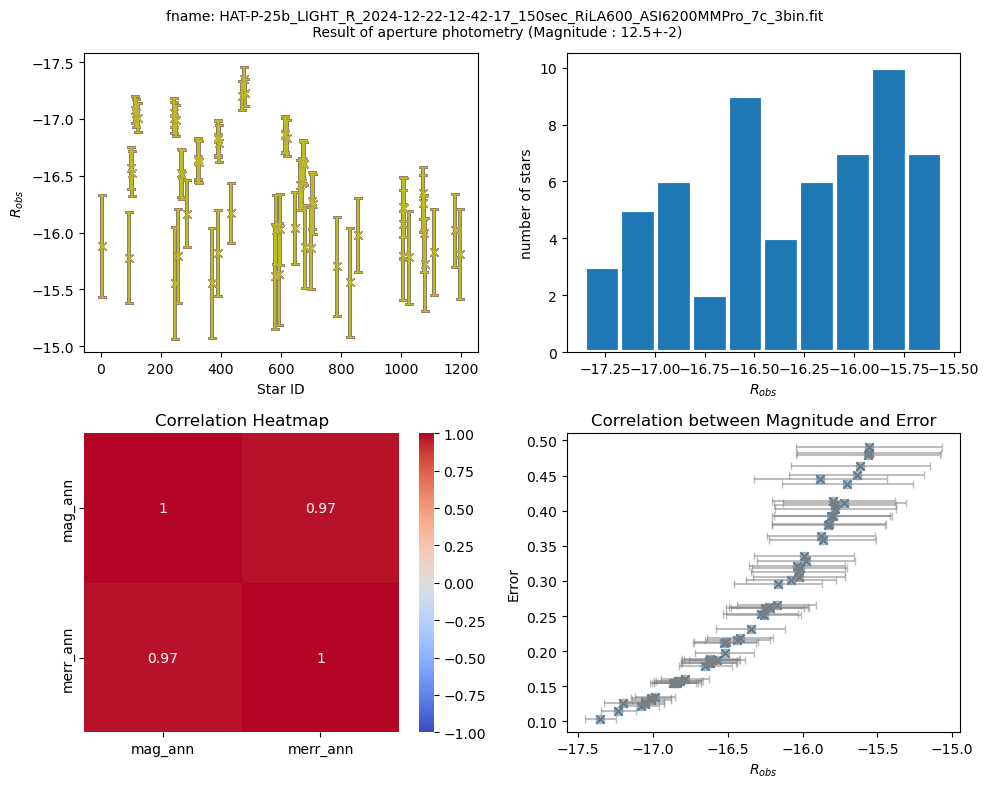

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8),
                        sharex=False, sharey=False, gridspec_kw=None)

for idx, row in df_apphot_sub.iterrows():
    im0 = axs[0, 0].errorbar(df_apphot_sub["id"],
                df_apphot_sub[f"mag_ann"], yerr=df_apphot_sub["merr_ann"],
                marker='x',
                ls='none',
                #ms=10,
                capsize=3)

axs[0, 0].invert_yaxis()
axs[0, 0].set(
    xlabel='Star ID',
    ylabel=f"${{{flt}}}_{{obs}}$"
    )

style = {'edgecolor': 'white', 'linewidth': 3}
im1 = axs[0, 1].hist(df_apphot_sub[f"mag_ann"],
            **style)
axs[0, 1].set(
    xlabel=f"${{{flt}}}_{{obs}}$",
    ylabel="number of stars"
    )

# 상관관계 계산
data =  df_apphot_sub[[f"mag_ann", "merr_ann"]]
corr = data.corr()

# 히트맵 그리기
im2 = sns.heatmap(corr, annot=True, cmap='coolwarm',
                    vmin=-1, vmax=1, center=0, ax = axs[1, 0])
axs[1, 0].set(
    title = 'Correlation Heatmap',
    )

axs[1, 1].scatter(df_apphot_sub[f"mag_ann"], df_apphot_sub["merr_ann"], marker='x',)
axs[1, 1].errorbar(x=df_apphot_sub[f"mag_ann"], y=df_apphot_sub["merr_ann"],
            yerr=None, xerr=df_apphot_sub["merr_ann"], fmt="o", color="gray", capsize=3, alpha=0.5)
axs[1, 1].set(
    title = "Correlation between Magnitude and Error",
    xlabel=f"${{{flt}}}_{{obs}}$",
    ylabel="Error",
    )

plt.suptitle(f"fname: {fpath.name}\n Result of aperture photometry (Magnitude : {Mag_target}±a})", fontsize=10,)

plt.tight_layout()
plt.savefig(f"{APERPRESULTDIR}_Result_of_aperture_photometry.png")

plt.show()
# plt.close()